In [5]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'src/'))

import pandas as pd
pd.set_option('display.max_rows', 500)


from oce_ecomm_abv_calculation.datasets.olist_brazilian_ecommerce import OlistBrazilianEcommerceDataset
from oce_ecomm_abv_calculation.datasets.uci_online_retail_ii import UCIOnlineRetailIIDataset

from oce_ecomm_abv_calculation.sample_statistics.vanilla import VanillaSampleStatistics
from oce_ecomm_abv_calculation.sample_statistics.oneway_bootstrap import OnewayBootstrapStatistics
from datetime import datetime


from matplotlib import pyplot as plt
import numpy as np

In [46]:
df = OlistBrazilianEcommerceDataset().standardized_customer_order_item_data_view()


In [54]:
df['r_SellingPrice'].mean()

120.37716648379588

In [61]:
# The seed of the RNG is made up of two components - the (hash of) the
# Unit ID and the index of the bootstrap sample being taken.
# Such seeding ensures the same unit in the same bootstrap sample gets the 
# same weight, while maintaining the randomness of weights overall.
# See Section 2.2.4 of https://arxiv.org/pdf/1304.7406.pdf

weights_generated = 4

df['weight_RandomizationUnit'] = (
    df['RandomizationUnitId'].apply(
        lambda ruid: np.random.default_rng(
            seed=abs(hash(ruid)) + weights_generated).poisson(lam=1.0)
    )
)
df['weight_SecondaryUnit'] = (
    df['SecondaryUnitId'].apply(
        lambda suid: np.random.default_rng(
            seed=abs(hash(suid)) + weights_generated).poisson(lam=1.0)
    )
)

df['weight'] = df['weight_RandomizationUnit'] * df['weight_SecondaryUnit']

In [62]:
# 119.5735304470257, 123.21655526434704, 120.98513065905219, 120.55122423010647

np.sum(df['r_SellingPrice'] * df['weight']) / np.sum(df['weight'])

119.90945024729209

In [2]:
vanilla = (
    VanillaSampleStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

In [3]:
vanilla.mean()

476.42959903262823

In [4]:
vanilla.standard_error()

7.183842985657441

In [5]:
oneway = (
    OnewayBootstrapStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

In [6]:
oneway.standard_error(num_bootstrap_means=500, verbose=True)

23.30019793460707

In [7]:
oneway.save_latest_result_as_pd_df()

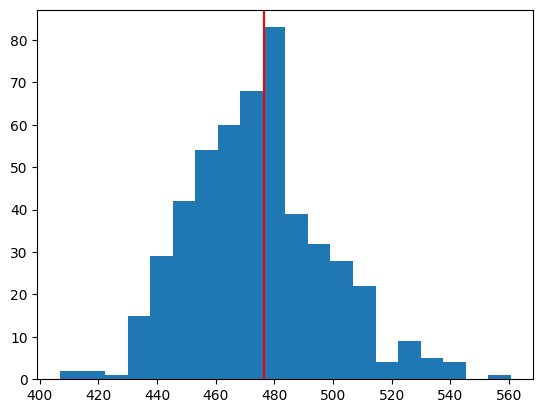

In [8]:
plt.hist(oneway.latest_means, bins=20)
plt.axvline(vanilla.mean(), c='red')